# Grado en ciencia de datos - Big Data

# Práctica 1 - Parte II - Ejercicios MapReduce

Se van a realizar varios ejercicios MapReduce usando de Spark. La dificultad de los ejercicios no está ligada al orden de los mismos, si se tiene dificultad en el ejercicio X se recomienda seguir con el siguiente. 

Los ejercicios 8 y 9 son los más complejos.

Ten en cuenta que una vez tengas en marcha Spark, podrás visualizar la evolución de cada trabajo de Spark en  <http://localhost:4040>

In [1]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local[*]").setAppName("My App")
sc = SparkContext(conf = conf)

25/11/29 13:38:24 WARN Utils: Your hostname, MacBook-Pro-de-Sergio.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
25/11/29 13:38:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/29 13:38:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Otros imports necesarios:

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
from test_helper import Test

## Ejercicio 1. Contar palabras

Crear una función MapReduce en Spark llamada `cuentaPalabras(filePath)` que cuente cuántas veces aparece cada palabra en un documento o conjunto de documentos de entrada

**Entrada:** Documento o documentos

**Salida:** (Palabra, Número de apariciones)

Pasos a seguir:
1. Leer el fichero. Cada línea es un elemento del RDD.
2. Dividir las líneas en palabras.
3. Filtrar palabras vacías.
4. Contar las occurrencias de cada palabra.
5. Devolver al driver las 10 palabras más repetidas


In [3]:
def cuentaPalabras(filePath):
    rdd = sc.textFile(filePath)
    count = rdd.flatMap(lambda line: line.split(" ")).filter(lambda x: x.strip() != "").map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
    result = count.takeOrdered(10, key=lambda x: -x[1]) #-x es para orden descendente
    return result

result = cuentaPalabras("./datos/pg2000.txt")

El programa debe ser capaz de pasar los siguientes tests

In [4]:
top10Quijote = cuentaPalabras("./datos/pg2000.txt")
print(top10Quijote)
Test.assertEquals(top10Quijote, [(u'que', 19429), (u'de', 17988), (u'y', 15894), (u'la', 10200), 
                          (u'a', 9575), (u'el', 7957), (u'en', 7898), (u'no', 5611), 
                          (u'se', 4690), (u'los', 4680)],
                  'Resultado incorrecto')

[('que', 19429), ('de', 17988), ('y', 15894), ('la', 10200), ('a', 9575), ('el', 7957), ('en', 7898), ('no', 5611), ('se', 4690), ('los', 4680)]
1 test passed.


### Parte 2 - Mejorando la cuenta de palabras
Utiliza la función `eliminarPuntuacion(text)` para contar todas las palabras igual independientemente de las mayúsculas, los signos de puntuación etc.

Pasos a seguir:
1. Leer el fichero. Cada línea es un elemento del RDD.
2. Eliminar los signos de puntuación.
2. Dividir las líneas en palabras.
3. Filtrar palabras vacías.
4. Contar las occurrencias de cada palabra.
5. Devolver al driver las 10 palabras más repetidas

In [5]:
import re
def eliminaSignosPuntuacion(text):
    """Elimina los signos de puntuación, pasa las palabras a minúsculas y elimina los espacios de más antes y después"""
    acentos = re.compile(r'[^0-9a-zA-ZñÑáéíóúÁÉÍÓÚ ]')
    return acentos.sub('', text.lower()).strip()

print(eliminaSignosPuntuacion('Hola!, Qué tal?'))
print(eliminaSignosPuntuacion(' Sin barras_bajas!'))
print(eliminaSignosPuntuacion(' *      Elimina puntación y espacios  * '))

hola qué tal
sin barrasbajas
elimina puntación y espacios


In [6]:
def cuentaPalabras(filePath):
    rdd = sc.textFile(filePath)
    eliminar_signos = rdd.flatMap(lambda line: eliminaSignosPuntuacion(line).split(" "))
    eliminar_vacios = eliminar_signos.filter(lambda x: x.strip() != "")
    conteo = eliminar_vacios.map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
    resultado = conteo.takeOrdered(10, key=lambda x: -x[1])
    return resultado

In [7]:
top10Quijote = cuentaPalabras("./datos/pg2000.txt")
Test.assertEquals(top10Quijote, [('que', 20626), ('de', 18217), ('y', 18188), ('la', 10363), ('a', 9880),
                                ('en', 8241), ('el', 8210), ('no', 6345), ('los', 4748), ('se', 4690)],
                  'Resultado incorrecto')

1 test passed.


## Ejercicio 2. Histograma de repeticiones

Obtener un histograma del número de repeticiones de las palabras, es decir, cuántas palabras se repiten X veces:
* 1 vez – 3 palabras
* 2 veces – 10 palabras
* 3 veces – 20 palabras
* ...

Para ello crea una función MapReduce en Spark llamada `histogramaRepeticiones(filePath)`. Esta función NO debe hacerr uso de la función `cuentaPalabras(filePath)` del programa anterior aunque compartirá parte de su código. Todo debe realizarse mediante RDDs salvo el `collect()` final que devolverá una lista. La lista debe de estar ordenada por el número de veces. Continúa utilizando la función `eliminarPuntuacion(text)` para contar igual todas las palabras.

**Entrada:** Documento o documentos

**Salida:** (X veces, Número de palabras)


In [8]:
# Traer lo 20 primeros para que no tarde mucho.
def histogramaRepeticiones(filePath):
    rdd = sc.textFile(filePath)
    eliminar_signos = rdd.flatMap(lambda line: eliminaSignosPuntuacion(line).split(" "))
    eliminar_vacios = eliminar_signos.filter(lambda x: x.strip() != "")
    conteo = eliminar_vacios.map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
    map_conteo = conteo.map(lambda value: (value[1], 1))
    resultado = map_conteo.reduceByKey(lambda x, y: x + y).takeOrdered(10, key=lambda x: -x[1])
    return resultado

El programa debe ser capaz de pasar los siguientes tests

In [9]:
histQuijote = histogramaRepeticiones("./datos/pg2000.txt")
Test.assertEquals(histQuijote[:10], [(1, 11583), (2, 3664), (3, 1860), (4, 1147), (5, 780),
                                     (6, 552), (7, 422), (8, 334), (9, 261), (10, 227)],
                  'Resultado incorrecto')

1 test passed.


Podemos realizar un gráficos a partir de los datos con matplotlib

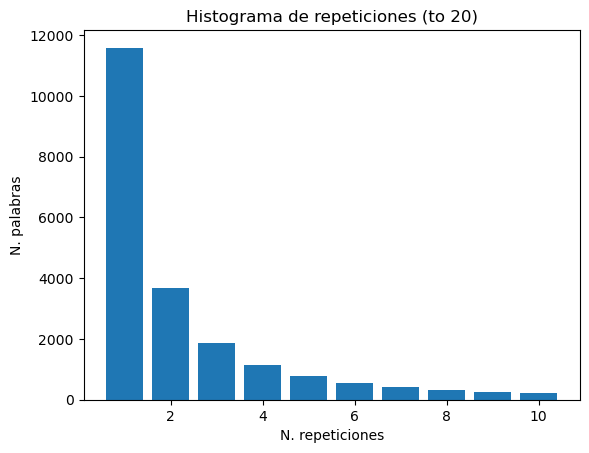

In [10]:
(x_values, y_values) = zip(*histQuijote[:20])
plt.bar(x_values, y_values)
plt.title('Histograma de repeticiones (to 20)')
plt.xlabel('N. repeticiones')
plt.ylabel('N. palabras')
plt.show()

## Ejercicio 3. Histograma de la longitud de las palabras


Obtener un histograma de la longitud de las palabras en un documento o conjunto de documentos. Es decir, cada longitud de palabra cuántas veces se repite:
* Longitud 1 – 100 veces
* Longitud 2 – 200 veces
* Longitud 3 – 400 veces
* ...

Para ello crea una función MapReduce en Spark llamada `histogramaLongitud(filePath)`. Todo debe realizarse mediante RDDs salvo el `collect()` final que devolverá una lista. La lista debe de estar ordenada por la longitud de las palabras. Continúa utilizando la función `eliminarPuntuacion(text)` para contar igual todas las palabras.

**Entrada:** Documento o documentos

**Salida:** (Longitud, Número de palabras)


**NOTA: Asumimos que no existen palabras de longitud mayor que 16 por lo que estas no deben aparecer en el resultado**


In [11]:
def histogramaLongitud(filePath):
    rdd = sc.textFile(filePath)
    eliminar_signos = rdd.flatMap(lambda line: eliminaSignosPuntuacion(line).split(" "))
    eliminar_vacios = eliminar_signos.filter(lambda x: x.strip() != "" and len(x) < 17)
    conteo = eliminar_vacios.map(lambda word: (len(word), 1)).reduceByKey(lambda x, y: x + y)
    conteo_ordenado = conteo.sortBy(lambda x: x[0])
    return conteo_ordenado.collect()

El programa debe ser capaz de pasar los siguientes tests

In [12]:
histLongitudQuijote = histogramaLongitud("./datos/pg2000.txt")
print(histLongitudQuijote)
Test.assertEquals(histLongitudQuijote, [(1, 29393), (2, 89911), (3, 66933), (4, 37132), (5, 46076), (6, 37020), 
                                        (7, 30252), (8, 20239), (9, 13265), (10, 7538), (11, 3340), (12, 1770), 
                                        (13, 847), (14, 347), (15, 118), (16, 43)],
                  'Resultado incorrecto')

[(1, 29393), (2, 89911), (3, 66933), (4, 37132), (5, 46076), (6, 37020), (7, 30252), (8, 20239), (9, 13265), (10, 7538), (11, 3340), (12, 1770), (13, 847), (14, 347), (15, 118), (16, 43)]
1 test passed.


### Pinta el histograma de las palabras con matplotlib

Podemos realizar un gráficos a partir de los datos con matplotlib

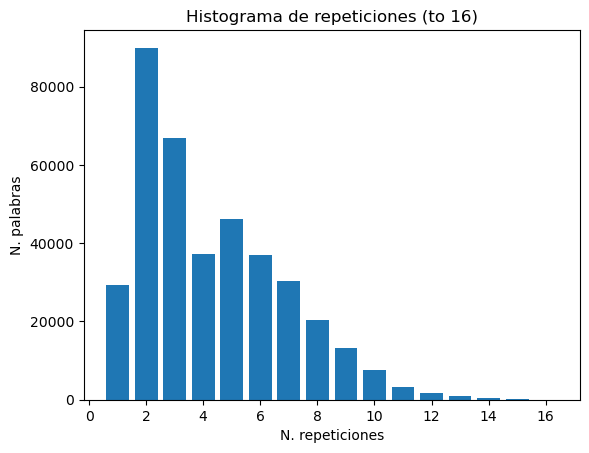

In [13]:
(x_values, y_values) = zip(*histLongitudQuijote)
plt.bar(x_values, y_values)
plt.title('Histograma de repeticiones (to 16)')
plt.xlabel('N. repeticiones')
plt.ylabel('N. palabras')
plt.show()

## Ejercicio 4. Calcula la longitud media de las palabras en un texto

Obtener la longitud media de las palabras en un documento o conjunto de documentos. Es decir, de media qué longitud tienen las palabras. 

**NOTA: Asumimos que no existen palabras de longitud mayor que 16 por lo que estas no deben contar para la media**

Para ello crea una función MapReduce en Spark llamada `longitudMedia(filePath)`. 

**Entrada:** Documento o documentos

**Salida:** Longitud media




In [14]:
def longitudMedia(filePath):
    rdd = sc.textFile(filePath)
    eliminar_signos = rdd.flatMap(lambda line: line.split(" ")).filter(lambda x: x.strip() != "" and len(x) < 17)
    
    conteo = eliminar_signos.map(lambda word: (1, (1, len(word))))\
                            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    result = conteo.first()
    return result[1][1] / result[1][0]
    
    #media = conteo.map(lambda x: x[1][1] / x[1][0])
    #print(media.collect())
    

El programa debe ser capaz de pasar los siguientes tests

In [15]:
from test_helper import Test
longMedia = longitudMedia("./datos/pg2000.txt")
Test.assertEquals(round(longMedia,5), 4.48426,
                  'Resultado incorrecto')

1 test passed.


## Ejercicio 5. Buscar lista de amigos comunes entre dos amigos

Obtener la lista de amigos comunes entre cada par de amigos. Es decir, para cada dos personas que son amigos en una red social, encontrar todos sus amigos comunes. 

Para ello crea una función MapReduce en Spark llamada `amigosComunes(filePath)`. 

**Entrada:** Fichero con formato, persona -> lista de amigos

**Salida:** (par de amigos, lista de amigos comunes)


**Ejemplo**
Supongamos que cada letra corresponde a una persona (A, B, C, D, E...)

Para la entrada

A -> B C D

B -> A C D E

C -> A B D E

D -> A B C E

E -> B C D

Se debe obtener la salida

(A B) -> (C D)

(A C) -> (B D)

(A D) -> (B C)

(B C) -> (A D E)

(B D) -> (A C E)

(B E) -> (C D)

(C D) -> (A B E)

(C E) -> (B D)

(D E) -> (B C)

**NOTA: CUIDADO, las listas no pueden usarse como claves en pySpark al no ser inmutables. Deben usarse tuplas, para convertir una lista a tupla usar `tuple(lista)`**

In [16]:
def amigosComunes(filePath):
    rdd = sc.textFile(filePath)
    enlaces = rdd.map(lambda line: line.split(" -> ")).map(lambda x: (x[0], x[1].split()))
    amigosComunes = enlaces.flatMap(lambda x: [(tuple(sorted([x[0], v])), set([u for u in x[1] if u != v])) for v in x[1]])
    resultado = amigosComunes.reduceByKey(lambda x, y: x.intersection(y)).map(lambda x: (x[0], list(x[1])))
    return resultado.collect()

amigosComunes("./datos/amigos.txt")
    

[(('A', 'D'), ['B', 'C']),
 (('B', 'C'), ['E', 'D', 'A']),
 (('D', 'E'), ['B', 'C']),
 (('A', 'B'), ['C', 'D']),
 (('A', 'C'), ['B', 'D']),
 (('B', 'D'), ['E', 'C', 'A']),
 (('B', 'E'), ['C', 'D']),
 (('C', 'D'), ['B', 'E', 'A']),
 (('C', 'E'), ['B', 'D'])]

El programa debe ser capaz de pasar los siguientes tests

In [17]:
Test.assertEquals(sorted(map(lambda t: (t[0], sorted(t[1])), amigosComunes("./datos/amigos.txt"))), 
                  sorted(map(lambda t: (t[0], sorted(t[1])), [((u'A', u'B'), [u'C', u'D']), ((u'A', u'C'), [u'B', u'D']),
                                                       ((u'A', u'D'), [u'C', u'B']), ((u'B', u'C'), [u'A', u'E', u'D']),
                                                       ((u'B', u'D'), [u'A', u'C', u'E']), ((u'B', u'E'), [u'C', u'D']), 
                                                       ((u'C', u'D'), [u'A', u'B', u'E']), ((u'C', u'E'), [u'B', u'D']), 
                                                       ((u'D', u'E'), [u'C', u'B'])])), 
                  'Resultado incorrecto')

1 test passed.


## Ejercicio 6. Top 20 de artistas (grupos) más escuchados en LastFM

Crea una función MapReduce en Spark llamada `top20artistas(filePath)` que obtenga la lista de los 20 artistas más escuhados en LastFM. Para ello, haz uso del fichero `lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv` que tiene el siguiente formato 

`Id_usuario   id_artista    nombre_artista    veces_escuchado`      (separado por tabuladores, `\t`).


**Entrada:** Fichero LastFM 

**Salida:** Lista de los 20 grupos más escuhados ordenada (de mayor a menor)

**NOTA: Para las pruebas iniciales puedes utilizar las 3000 primeras líneas del fichero que están en `sample3000_usersha1-artmbid-artname-plays.tsv`** 


In [18]:
def top20artistas(filePath):
    rdd = sc.textFile(filePath)
    lines = rdd.map(lambda line: line.split("\t"))
    conteo = lines.map(lambda fields: (fields[2], int(fields[3]))).reduceByKey(lambda x, y: x + y).takeOrdered(20, key=lambda x: -x[1])
    return conteo

top20artistasSmall = top20artistas('./datos/lastfm-dataset-360K/sample3000_usersha1-artmbid-artname-plays.tsv')


El programa debe ser capaz de pasar los siguientes tests

Mientras se ejecuta la versión grande puedes ver su evolución en <http://localhost:4040>

Si tarda demasiado con que pase el primer test es suficiente

In [19]:
top20artistasSmall = top20artistas('./datos/lastfm-dataset-360K/sample3000_usersha1-artmbid-artname-plays.tsv')
Test.assertEquals(top20artistasSmall, [(u'radiohead', 13117), (u'the most serene republic', 12763), (u'nine inch nails', 11686),
                                       (u'arctic monkeys', 10943), (u'stars', 9045), (u'the beatles', 8682), (u'3 na bossa', 7925),
                                       (u'coldplay', 7899), (u'broken social scene', 6711), (u'kingston wall', 5992), (u'bright eyes', 5914),
                                       (u'the libertines', 5727), (u'have heart', 5361), (u'boris', 5337), (u'sigur r\xf3s', 5177), 
                                       (u'luminous orange', 5120), (u'blink-182', 4660), (u'they might be giants', 4558), (u'queen', 4451), 
                                       (u'bob dylan', 4443)],
                  'Resultado incorrecto en Small')

top20artistasBig = top20artistas('./datos/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv')
Test.assertEquals(top20artistasBig, [(u'the beatles', 30499140), (u'radiohead', 27452136), (u'coldplay', 16701858), (u'pink floyd', 15965959), 
                                     (u'metallica', 15498759), (u'muse', 15463089), (u'nine inch nails', 14090643), (u'red hot chili peppers', 13562637),
                                     (u'linkin park', 12848569), (u'system of a down', 11927204), (u'in flames', 11295957), 
                                     (u'death cab for cutie', 10587605), (u'placebo', 9848924), (u'nightwish', 9765770), (u'the killers', 9607866), 
                                     (u'iron maiden', 9509435), (u'bob dylan', 9454759), (u'nirvana', 9284068), (u'depeche mode', 9243291), 
                                     (u'rammstein', 8809758)],
                  'Resultado incorrecto en Big')

1 test passed.


1 test passed.


## Ejercicio 7. Top 10 de artistas (grupos) con más usuarios únicos que los han escuchado en LastFM

Crea una función MapReduce en Spark llamada `top20artistasUnicos(filePath)` que obtenga la lista de los 20 artistas más escuhados en LastFM en cuanto al número de usuarios únicos que lo han escuhado. Para ello, haz uso del fichero `lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv` que tiene el siguiente formato 

`Id_usuario   id_artista    nombre_artista    veces_escuchado`      (separado por tabuladores, `\t`).


**Entrada:** Fichero LastFM 

**Salida:** Lista de los 20 grupos más escuhados por usuarios únicos ordenada (de mayor a menor)

**NOTA: Para las pruebas iniciales puedes utilizar las 3000 primeras líneas del fichero que están en `sample3000_usersha1-artmbid-artname-plays.tsv`** 

**NOTA2: Hay varias formas de resolver el problema, piensa cuál es la más eficiente (por ejemplo, la que menor tráfico de red consume) - relacionado con las reproducciones únicas**


In [20]:
def top20artistasUnicos(filePath):
    rdd = sc.textFile(filePath)
    lines = rdd.map(lambda line: line.split("\t"))
    conteo = lines.map(lambda fields: ((fields[2], {fields[0]}))).reduceByKey(lambda x, y: (x.union(y)))
    conteo_unicos = conteo.map(lambda x: (x[0], len(x[1]))).takeOrdered(20, key=lambda x: -x[1])
    return conteo_unicos

El programa debe ser capaz de pasar los siguientes tests

Mientras se ejecuta la versión grande puedes ver su evolución en <http://localhost:4040>

Si tarda demasiado con que pase el primer test es suficiente

In [21]:
top20artistasUnicosSmall = top20artistasUnicos('./datos/lastfm-dataset-360K/sample3000_usersha1-artmbid-artname-plays.tsv')
Test.assertEquals(top20artistasUnicosSmall[:3], [(u'radiohead', 18), (u'the beatles', 16), (u'coldplay', 11)],
                  'Resultado incorrecto en Small')

top20artistasUnicosBig = top20artistasUnicos('./datos/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv')
Test.assertEquals(top20artistasUnicosBig, [(u'radiohead', 77348), (u'the beatles', 76339), (u'coldplay', 66738), 
                                           (u'red hot chili peppers', 48989), (u'muse', 47015), (u'metallica', 45301), 
                                           (u'pink floyd', 44506), (u'the killers', 41280), (u'linkin park', 39833), (u'nirvana', 39534), 
                                           (u'system of a down', 37324), (u'queen', 34215), (u'u2', 33247), (u'daft punk', 33040), 
                                           (u'the cure', 32673), (u'led zeppelin', 32341), (u'placebo', 32111), (u'depeche mode', 31966), 
                                           (u'david bowie', 31907), (u'bob dylan', 31840)],
                  'Resultado incorrecto en Small')

1 test passed.


1 test passed.


## Ejercicio 8. Búsqueda del elemento más parecido (vecino más cercano)

Crea una función MapReduce en Spark llamada `vecinoMasCercano(filePath, vector)` que obtenga el índice (fila comenzando a contar desde 0) del vector más parecido al vector de entrada. El fichero contendrá un vector por línea. El fichero de ejemplo es `vectores.txt` y contiene vectores de dimensión 3.

Para calcular la distancia entre dos vectores `A, B` utiliza la distancia Euclidea:

$$ dist(A, B) = \sqrt{ \sum^{N}_{i=1}{ (A[i] - B[i])^2 } } $$

Donde $N$ es la dimensión de los vectores. Para el fichero de ejemplo tenemos que $N = 3$ aunque debe programarse de manera genrérica para cualquier valor de $N$

**Entrada:** Fichero con un vector por línea y vector (representado como una lista)

**Salida:** Índice del vector más parecido

**Importante**

Pasos a seguir:
* Crea una función `dist(A, B)` que calcule la distancia entre dos vectores. Utiliza numpy, es decir, asume que la función recibe dos vectores tipo numpy.array.
* Crea una función que lea el fichero y devuelva un RDD de arrays (numpy arrays) - pista: consultar ` np.fromstring` - <https://docs.scipy.org/doc/numpy/reference/generated/numpy.fromstring.html>
* Utiliza una variable tipo broadcast para distribuir el vector a todas las particiones - Si fuera muy grande sería mucho más eficiente
* Para hacer uso del índice del elemento en un RDD considera el método de RDDs `zipWithIndex()` que transforma el RDD de elementos v a un RDD de elementos (v, index) <http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex>

Debes implementar `vecinoMasCercano(filePath, vector)` de dos formas:
1. Utilizando la función `map` - versión `vecinoMasCercano(filePath, vector)`
2. Utilizando la función `mapPartitions` - versión `vecinoMasCercanoMapPartitions(filePath, vector)` - Recuerda que en este caso en vez de trabajar elemento por elemento trabajamos con un iterador que apunta a todos los elementos de la partición

In [22]:
import numpy as np
def dist(A, B):
    return np.sqrt(np.sum((A-B)**2))

def parseaFichero(filePath):
    rdd = sc.textFile(filePath)
    arrays = rdd.map(lambda line: np.fromstring(line, sep=','))
    return arrays


def vecinoMasCercano(filePath, vector):
    vect_b = sc.broadcast(np.array(vector))
    rdd = parseaFichero(filePath)
    indexed = rdd.zipWithIndex()
    dists = indexed.map(lambda vi: (dist(vi[0], vect_b.value), vi[1]))
    resultado = dists.min(key=lambda x: x[0])
    return resultado[1]
    
def combineCtrs(x, y):
    if x is None:
        return y
    if y is None:
        return x
    return x if x[0] < y[0] else y

def fastDst(vects):
    best = None
    for vec, idx in vects:
        d = dist(vec, vect_b.value)
        if best is None or d < best[0]:
            best = (d, idx)
    if best is None:
        return iter([])
    return iter([best])
    

def vecinoMasCercanoMapPartitions(filePath, vector):
    global vect_b
    vect_b = sc.broadcast(np.array(vector))

    rdd = parseaFichero(filePath)
    indexed = rdd.zipWithIndex()

    # fastDst cumple: solo un parámetro
    candidatos = indexed.mapPartitions(fastDst)
    resultado = candidatos.reduce(combineCtrs)

    return resultado[1]

In [23]:
print (vecinoMasCercanoMapPartitions('./datos/vectores.txt', [0.3, 0.0, 1.0]))

35646


El programa debe ser capaz de pasar los siguientes tests

Mientras se ejecuta la versión grande puedes ver su evolución en <http://localhost:4040>

In [24]:
A = np.array([1, 2, 1, 4])
B = np.array([1, 3, 3, 4])
Test.assertEquals(round(dist(A, B), 5), 2.23607, "La función dist(A, B) es incorreta")
Test.assertEquals(parseaFichero('./datos/vectores.txt').first().tolist(), [0.2215745341345421, 0.7678204549927838, 0.3989186468051199],
                  "La función parseaFichero es incorreta")
Test.assertEquals(parseaFichero('./datos/vectores.txt').count(), 100000,
                  "La función parseaFichero es incorreta")
Test.assertEquals(vecinoMasCercano('./datos/vectores.txt', [0.6, 0.5, 0.1]), 89697,
                  "La función vecinoMasCercano es incorreta")
Test.assertEquals(vecinoMasCercano('./datos/vectores.txt', [0.3, 0.0, 1.0]), 35646,
                  "La función vecinoMasCercano es incorreta")
Test.assertEquals(vecinoMasCercanoMapPartitions('./datos/vectores.txt', [0.6, 0.5, 0.1]), 89697,
                  "La función vecinoMasCercanoMapPartitions es incorreta")
Test.assertEquals(vecinoMasCercanoMapPartitions('./datos/vectores.txt', [0.3, 0.0, 1.0]), 35646,
                  "La función vecinoMasCercanoMapPartitions es incorreta")

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


## Ejercicio 9. Búsqueda del elemento más parecido (vecino más cercano) a varios vectores

Crea una función MapReduce en Spark llamada `vecinoMasCercanoLista(filePath, lista[vector])` que obtenga el índice (fila comenzando a contar desde 0) del vector más parecido cada uno de los vectores de entrada en la lista. Es decir, reutiliza el código del ejercicio anterior para obtener los índices más cercanos a los vectores en la lista. Recuerda hacerlo eficiéntemente aprovechando las características in-memory de Spark.

**Entrada:** Fichero con un vector por línea y lista de vectores (representada como una lista de listas)

**Salida:** Lista de índices de los vectores más parecidos

**Importante**
Puede reusar cualquiera de las dos versiones aplicadas anteriormente, pero hazlo de manera eficiente. No reimplementes la función `dist(A, B)` ni la función de lectura.


In [25]:
def combineCtrs(x, y):
    if x is None:
        return y
    if y is None:
        return x
    return x if x[0] < y[0] else y

def fastDst(vects):
    best = None
    for vec, idx in vects:
        d = dist(vec, vect_b.value)
        if best is None or d < best[0]:
            best = (d, idx)
    if best is None:
        return iter([])
    return iter([best])

def vecinoMasCercanoLista(filePath, vectores):
    rdd = parseaFichero(filePath)
    indexed = rdd.zipWithIndex().cache()
    resultados = []
    for v in vectores:
        global vect_b
        vect_b = sc.broadcast(np.array(v))
        candidatos = indexed.mapPartitions(fastDst)
        minimo = candidatos.reduce(combineCtrs)
        resultados.append(minimo[1])
    return resultados

El programa debe ser capaz de pasar los siguientes tests

Mientras se ejecuta la versión grande puedes ver su evolución en <http://localhost:4040>

In [26]:
Test.assertEquals(vecinoMasCercanoLista('./datos/vectores.txt', [[0.6, 0.5, 0.1], [0.3, 0.0, 1.0]]), [89697, 35646],
                  "La función vecinoMasCercanoLista es incorreta")

1 test passed.


## Ejercicio 10. URLs de páginas que se enlazan mutuamente

Diseña un programa MapReduce para obtener las URLs de las páginas que se enlazan mutuamente a partir de los enlaces de cada una de las páginas.

Para ello, tenemos un fichero de entrada con formato URL -> lista de URLs a partir del cual se debe obtener una salida en la que únicamente aparezcan los pares de URLs que se enlazan mutuamente.

**Entrada:** Fichero con formato, URL -> lista de URLs 

**Salida:** (par de URLs mutuamente enlazada)

**Ejemplo**
Supongamos que cada letra se corresponde con una URL (A, B, C, D, E...)

Para la entrada

A -> B D

B -> A C D E

C -> B E

D -> B C E

E -> B C D

Se debe obtener la salida

(A B) 
(B C) 
(B D) 
(B E) 
(C E)
(D E) 

**NOTA: CUIDADO, las listas no pueden usarse como claves en pySpark al no ser inmutables. Deben usarse tuplas, para convertir una lista a tupla usar `tuple(lista)`**

In [27]:
def paginasEnlacesMutuos(filePath):
    rdd = sc.textFile(filePath)
    enlaces = rdd.map(lambda line: line.split(" -> "))
    lista_vecinos = enlaces.map(lambda x: (x[0], x[1].split())).flatMap(lambda x: [(tuple(sorted([x[0], v])), 1) for v in x[1]])
    reduce = lista_vecinos.reduceByKey(lambda x, y: x + y).filter(lambda x: x[1] > 1).sortBy(lambda x: x[0]).keys().collect()
    return reduce

El programa debe pasar el siguiente test.

In [28]:
Test.assertEquals(paginasEnlacesMutuos("./datos/urls.txt"), [(u'A', u'B'), (u'B', u'C'), (u'B', u'D'), 
                                                        (u'B', u'E'), (u'C', u'E'), (u'D', u'E')], 
                  'Resultado incorrecto')

1 test passed.


## Ejercicio 11. Calcular el precio medio de las casas por su edad
Descargamos un dataset con información de casas de California. 
Se pide calcular el precio medio de las casas ordenadas por fecha de construcción (menor a mayor).

In [29]:
from sklearn import datasets

Se puede ver la información del dataset en el siguiente enlace: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes

In [30]:
# Hacemos un pequeño prepocesamiento, ya que es un dataset de clasificación agrupamos data y target.
def preprocesamiento():
    ds = datasets.fetch_california_housing()
    return sc.parallelize(np.vstack((ds.data[:, 0], ds.data[:, 1], ds.data[:, 2], ds.target)).T)#Selecciono sólo unas columnas para no hacerlo muy pesado, la idea es la misma.

housingRDD = preprocesamiento()
housingRDD.collect()

[array([ 8.3252    , 41.        ,  6.98412698,  4.526     ]),
 array([ 8.3014    , 21.        ,  6.23813708,  3.585     ]),
 array([ 7.2574    , 52.        ,  8.28813559,  3.521     ]),
 array([ 5.6431   , 52.       ,  5.8173516,  3.413    ]),
 array([ 3.8462    , 52.        ,  6.28185328,  3.422     ]),
 array([ 4.0368    , 52.        ,  4.76165803,  2.697     ]),
 array([ 3.6591    , 52.        ,  4.93190661,  2.992     ]),
 array([ 3.12      , 52.        ,  4.79752705,  2.414     ]),
 array([ 2.0804    , 42.        ,  4.29411765,  2.267     ]),
 array([ 3.6912    , 52.        ,  4.97058824,  2.611     ]),
 array([ 3.2031    , 52.        ,  5.47761194,  2.815     ]),
 array([ 3.2705    , 52.        ,  4.77247956,  2.418     ]),
 array([ 3.075     , 52.        ,  5.32264957,  2.135     ]),
 array([ 2.6736, 52.    ,  4.    ,  1.913 ]),
 array([ 1.9167    , 52.        ,  4.26290323,  1.592     ]),
 array([ 2.125     , 50.        ,  4.24242424,  1.4       ]),
 array([ 2.775     , 52.    

In [31]:
def histogramaEdadPrecio():
    data = preprocesamiento()
    edades_precios = data.map(lambda x: (x[1], (x[3], 1))).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    media_edad = edades_precios.map(lambda x: (x[0], x[1][0] / x[1][1])).sortByKey()
    return media_edad.collect()
    

histEdadPrecioCasa = histogramaEdadPrecio()

Para hacer más fácil la compresión de los datos los graficamos.

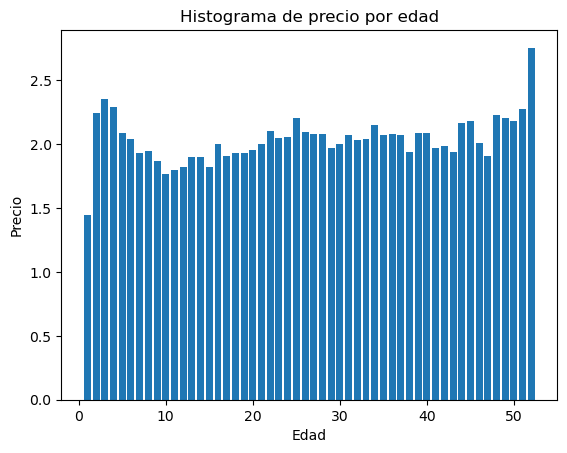

In [32]:
(x_values, y_values) = zip(*histEdadPrecioCasa)
plt.bar(x_values, y_values)
plt.title('Histograma de precio por edad')
plt.xlabel('Edad')
plt.ylabel('Precio')
plt.show()

Apuntar que en el gráfico anterior se muestra como la edad de las casas no es un atributo muy importante al parecer. Es bastante plano el histograma, poca varianza entre edades.

## Ejercicio 12 - Histograma de letra.

A partir del fichero del Quijote usado en anteriores ejercicios se pide elaborar un histograma con la frecuencia de aparición de cada letra del abecedario español (las 27 letras y 10 números). 

En primer usaremos la función eliminaSignosPuntuacionyTildes, la cual se encarga de eliminar los signos de puntuación, pasa las palabras a minúsculas y elimina los espacios de más antes y después.

In [33]:
import re
def eliminaSignosPuntuacionyTildes(text):
    """Elimina los signos de puntuación, pasa las palabras a minúsculas y elimina los espacios de más antes y después"""
    acentos = re.compile(r'[^0-9a-zA-ZñÑáéíóúüÁÉÍÓÚÜ ]')
    elimina_acentos=["áéíóúü","aeiouu"]
    new_texto=acentos.sub('', text.lower()).strip()
    return new_texto.translate(new_texto.maketrans(elimina_acentos[0],elimina_acentos[1]))

A continuación, completamos la función histogramaFrecuenciaLetra que obtiene un histograma con la frecuencia de cada letra.

In [34]:
def histogramaFrecuenciaLetra(filePath):
    rdd = sc.textFile(filePath)
    eliminar_signos = rdd.flatMap(lambda line: eliminaSignosPuntuacionyTildes(line).split(" "))
    letras = eliminar_signos.flatMap(lambda word: list(word))
    frecuencia_letras = letras.map(lambda letra: (letra, 1)).reduceByKey(lambda a, b: a + b)
    return frecuencia_letras.collect()

histogramaFrecuenciaLetra("./datos/pg2000.txt")

[('t', 63281),
 ('p', 35914),
 ('o', 163862),
 ('j', 10627),
 ('c', 60045),
 ('g', 17639),
 ('b', 24427),
 ('d', 87779),
 ('q', 32501),
 ('l', 89632),
 ('7', 8),
 ('0', 35),
 ('ñ', 4241),
 ('6', 11),
 ('4', 11),
 ('z', 6493),
 ('5', 13),
 ('3', 13),
 ('h', 20436),
 ('e', 231038),
 ('r', 102125),
 ('u', 80082),
 ('n', 109491),
 ('k', 133),
 ('f', 7967),
 ('i', 91196),
 ('y', 25443),
 ('m', 45024),
 ('v', 17976),
 ('a', 201517),
 ('s', 126490),
 ('w', 272),
 ('2', 16),
 ('1', 66),
 ('9', 12),
 ('x', 407),
 ('8', 11)]

Podemos realizar un gráficos a partir de los datos con matplotlib

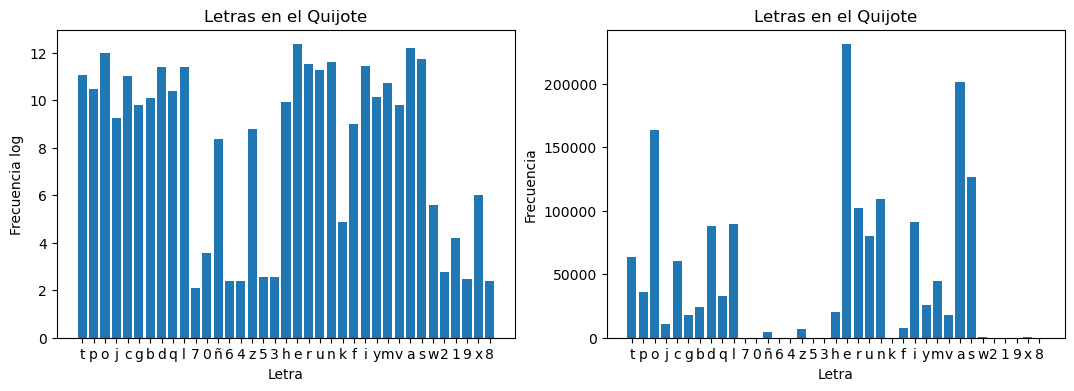

In [35]:
(x_values, y_values) = zip(*histogramaFrecuenciaLetra("./datos/pg2000.txt"))
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=[13, 4])
ax1.bar(x_values, np.log(y_values))

ax1.set_title('Letras en el Quijote')
ax1.set_xlabel('Letra')
ax1.set_ylabel('Frecuencia log')

ax2.bar(x_values, y_values)
ax2.set_title('Letras en el Quijote')
ax2.set_xlabel('Letra')
ax2.set_ylabel('Frecuencia')

plt.show()

## Ejercicio 14 - Área media tumor.

Para realizar este ejercicio primero debemos cargar el dataset breast_cancer disponible en sklearn.datasets. Una vez cargado el fichero nuestro objetivo será analizar si se aprecia alguna diferencia en el área promedio del tumor en función de su tipología (benigno o maligno).

In [36]:
# Primero realizamos una aproximación al datset imprimiendo una descripción.
print(datasets.load_breast_cancer().DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [37]:
# También podemos imprimir los nombres de las etiquetas.
print(datasets.load_breast_cancer().target_names)

['malignant' 'benign']


In [38]:
# Hacemos un pequeño prepocesamiento, ya que es un dataset de clasificación agrupamos data y target.
# Debemos seleccionar SOLO 3 COLUMNAS para no hacerlo muy pesado.
def seleccionVar_Cancer():
    ds = datasets.load_breast_cancer()
    return sc.parallelize(np.vstack((ds.data[:, 3], ds.target)).T)


cancerRDD = seleccionVar_Cancer()
cancerRDD.collect()

[array([1001.,    0.]),
 array([1326.,    0.]),
 array([1203.,    0.]),
 array([386.1,   0. ]),
 array([1297.,    0.]),
 array([477.1,   0. ]),
 array([1040.,    0.]),
 array([577.9,   0. ]),
 array([519.8,   0. ]),
 array([475.9,   0. ]),
 array([797.8,   0. ]),
 array([781.,   0.]),
 array([1123.,    0.]),
 array([782.7,   0. ]),
 array([578.3,   0. ]),
 array([658.8,   0. ]),
 array([684.5,   0. ]),
 array([798.8,   0. ]),
 array([1260.,    0.]),
 array([566.3,   1. ]),
 array([520.,   1.]),
 array([273.9,   1. ]),
 array([704.4,   0. ]),
 array([1404.,    0.]),
 array([904.6,   0. ]),
 array([912.7,   0. ]),
 array([644.8,   0. ]),
 array([1094.,    0.]),
 array([732.4,   0. ]),
 array([955.1,   0. ]),
 array([1088.,    0.]),
 array([440.6,   0. ]),
 array([899.3,   0. ]),
 array([1162.,    0.]),
 array([807.2,   0. ]),
 array([869.5,   0. ]),
 array([633.,   0.]),
 array([523.8,   1. ]),
 array([698.8,   0. ]),
 array([559.2,   0. ]),
 array([563.,   0.]),
 array([371.1,   0. ]),


In [39]:
def areaMedia():
    # Realizar un broadcast del dataset
    tipo_cancer = sc.broadcast(datasets.load_breast_cancer().target_names)
    # Llamamos a seleccionVar_Cancer y hacemos la area media.
    rdd = seleccionVar_Cancer().map(lambda x: (x[1], (x[0], 1)))\
        .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))\
        .map(lambda x: (x[0], x[1][0] / x[1][1]))\
        .map(lambda x: (tipo_cancer.value[int(x[0])], x[1]))\
        .sortBy(lambda x: x[1])
    return rdd.collect()


x = areaMedia()
print(x)

[('benign', 462.7901960784314), ('malignant', 978.3764150943394)]


In [40]:
assert x == [('benign', 462.7901960784314), ('malignant', 978.3764150943394)], "La funcion areaMedia es incorrecta"

## Ejercicio 15 - Kmeans.

En clase hemos visto cómo se puede resolver el algortimo k-Means con MapReduce. Ahora es tu turno para desarrollar las funciones necesarias para implementar el algoritmo k-Means en Spark (lógicamente, en distribuido).

Como prueba, puedes usar los siguientes datos correspondiente a un problema bi-dimensional que puedes dibujar.

| |$x_1$|$x_2$|
|-------------|-------------|-------------|
|Ejemplo 1|4|2|
|Ejemplo 2|2|1|
|Ejemplo 3|1|2|
|Ejemplo 4|2|2|
|Ejemplo 5|4|3|
|Ejemplo 6|5|3|
|Ejemplo 7|5|2|

In [41]:
import random
import math
lista = [(4, 2), (2, 1), (1, 2), (2, 2), (4, 3), (5, 3), (5, 2)]


def centroide_cercano(centroides, punto):
    centroide_cercano = centroides[0]
    distancia_minimo = math.inf
    for centroide in centroides:
        distancia = math.sqrt((punto[0]-centroide[0])**2 + (punto[1]-centroide[1])**2)
        if distancia < distancia_minimo:
            distancia_minimo = distancia
            centroide_cercano = centroide
    return centroide_cercano


centroides = [(2, 1), (4, 3)]


rdd = sc.parallelize(lista)
antiguos_centroides = centroides
while (True):
    map_centroides = rdd.map(lambda punto: (centroide_cercano(centroides, punto), (punto, 1))).reduceByKey(lambda x, y: ((x[0][0]+y[0][0], x[0][1]+y[0][1]), x[1]+y[1]))
    nuevos_centroides = map_centroides.map(lambda x: ((x[1][0][0] / x[1][1], x[1][0][1] / x[1][1])))
    nuevos_centroides.collect()
    if (nuevos_centroides.collect() == antiguos_centroides):
        break
    antiguos_centroides = nuevos_centroides.collect()

nuevos_centroides.collect()

[(4.5, 2.5), (1.6666666666666667, 1.6666666666666667)]